In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from src.dataset import SIModel
from src.approx_bc import abc_rejection_sampler
import seaborn as sns
from scipy.stats import norm, lognorm, multivariate_normal

In [33]:
sns.set_theme()
beta_true = [.05, .05, .15]
alpha = 0.1
gamma = 0.025 # 0.05
prior_mu = -3
prior_sigma = 1.5
n_zones = 2
N = 100
T = 52
K = 30

In [34]:
si_model = SIModel(alpha, gamma, beta_true, n_zones,
                   prior_mu, prior_sigma, N, T, summarize=False)
x_o = si_model.get_observed_data(29)
x_o = x_o.unflatten(1, (n_zones+1,T)).squeeze(0)

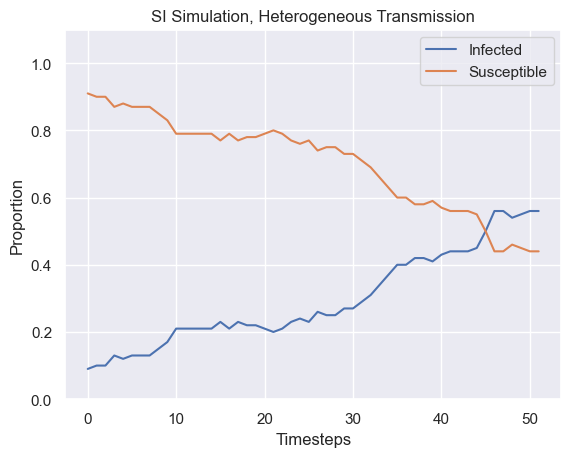

In [35]:
I_o = np.array(x_o[0])
S_o  = 1 - I_o
plt.plot(I_o, label="Infected")
plt.plot(S_o, label="Susceptible")
plt.legend(loc="upper right")
plt.xlabel("Timesteps")
plt.ylabel("Proportion")
plt.ylim(0, 1.1)
plt.title("SI Simulation, Heterogeneous Transmission")
plt.show()

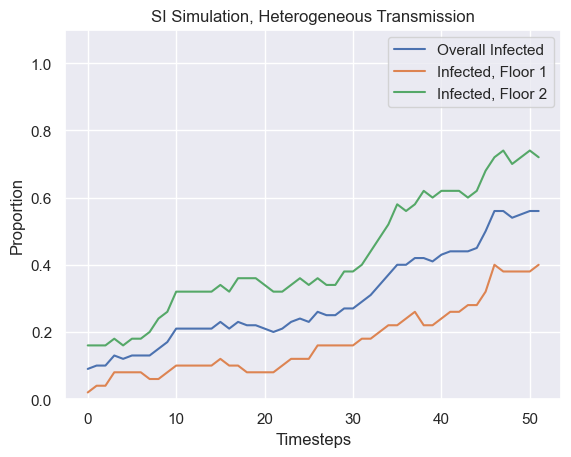

In [38]:
F1 = np.array(x_o[1])
F2  = np.array(x_o[2])
plt.plot(I_o, label="Overall Infected")
plt.plot(F1, label="Infected, Floor 1")
plt.plot(F2, label="Infected, Floor 2")
plt.legend(loc="upper right")
plt.xlabel("Timesteps")
plt.ylabel("Proportion")
plt.ylim(0, 1.1)
plt.title("SI Simulation, Heterogeneous Transmission")
plt.show()

## Prior

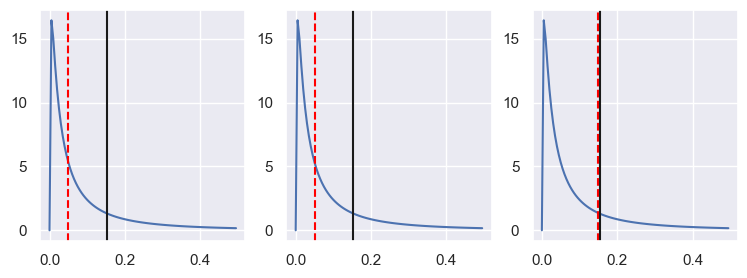

In [39]:
x = np.arange(0, 0.5, 0.005)
fig, axs = plt.subplots(1, 3)
fig.set_figheight(3)
fig.set_figwidth(9)

#TODO: generalize to multidim prior
prior_mean = np.exp(prior_mu + prior_sigma**2/2)

for i in range(3):
    sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(prior_mu), s=prior_sigma),
                ax=axs[i])
    axs[i].axvline(beta_true[i], color="red", linestyle="--")
    axs[i].axvline(prior_mean, color="k")
plt.show()

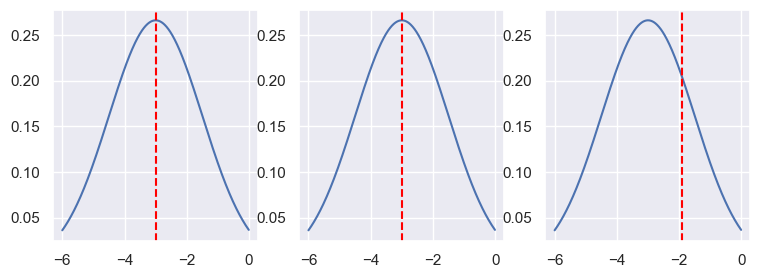

In [40]:
x = np.arange(-6, 0, 0.01)
fig, axs = plt.subplots(1, 3)
fig.set_figheight(3)
fig.set_figwidth(9)

#TODO: generalize to multidim prior
for i in range(3):
    sns.lineplot(x=x, y=norm.pdf(x, prior_mu, prior_sigma),
                ax=axs[i])
    axs[i].axvline(np.log(beta_true[i]), color="red", linestyle="--")
plt.show()

### Prior Predictive Check

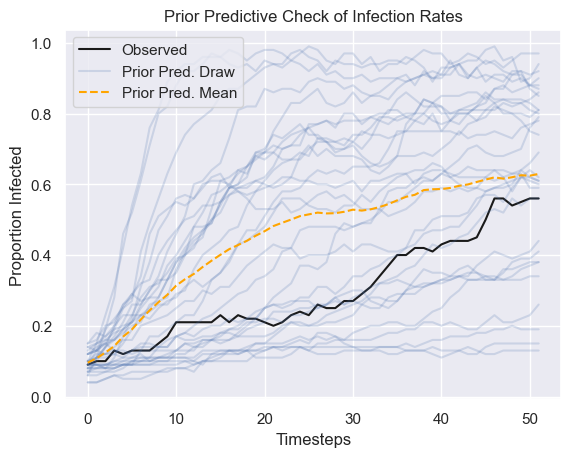

In [41]:
prior = norm(prior_mu, prior_sigma)
prior_sample = np.exp(prior.rvs(size=(K, n_zones+1), random_state=2))
prior_predictive = np.empty((K,n_zones+1,T))

for i in range(K):
    si_model = SIModel(alpha, gamma, prior_sample[i], 
                   2, prior_mu, prior_sigma,
                   N, T, summarize=False)
    x_rep = si_model.get_observed_data(i)
    x_rep = x_rep.unflatten(1, (n_zones+1, T)).squeeze(0)
    prior_predictive[i] =  np.array(x_rep)
prp_mean = prior_predictive.mean(0)[0]

labels = ["Prior Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(prior_predictive[:,0,:].T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(prp_mean, label="Prior Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.title("Prior Predictive Check of Infection Rates")
plt.ylabel("Proportion Infected")
plt.xlabel("Timesteps")
plt.show()

## ABC

#### Raw Data

In [32]:
si_model = SIModel(alpha, gamma, beta_true, 
                   n_zones, prior_mu, prior_sigma, 
                   N, T, summarize=False)
prior_sampler = lambda: si_model.sample_logbeta(1)
simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
x_o = si_model.get_observed_data(29)
x_o = x_o.reshape(-1, si_model.d_theta)

In [42]:
S = 100
epsilon = 0.014
posterior_sample, errors = abc_rejection_sampler(
    S, epsilon, prior_sampler, simulator, x_o, max_attempts=50000
)

Time lapsed: 40.41 seconds
With tolerance 0.014, acceptance rate: 0.006959
Total number of attempts: 14,370


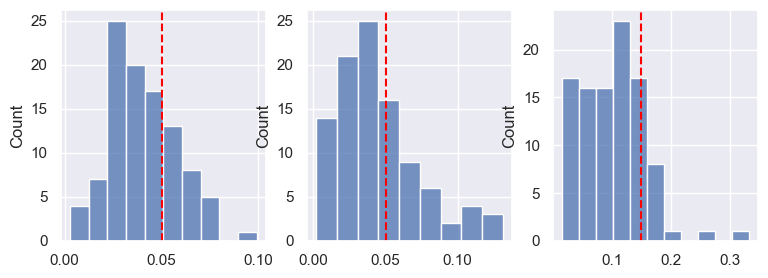

In [83]:
fig, axs = plt.subplots(1, 3)
fig.set_figheight(3)
fig.set_figwidth(9)

sns.histplot(np.exp(posterior_sample[:,0]),ax=axs[0])
axs[0].axvline(beta_true[0], color="red", linestyle="--")

sns.histplot(np.exp(posterior_sample[:,1]),ax=axs[1])
axs[1].axvline(beta_true[1], color="red", linestyle="--")

sns.histplot(np.exp(posterior_sample[:,2]),ax=axs[2])
axs[2].axvline(beta_true[2], color="red", linestyle="--")

plt.show()

#### Summary Statistic

In [62]:
si_model = SIModel(alpha, gamma, beta_true, 
                   n_zones, prior_mu, prior_sigma, 
                   N, T, summarize=True)
prior_sampler = lambda: si_model.sample_logbeta(1)
simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
x_o = si_model.get_observed_data(29)

In [65]:
S = 100
epsilon = 0.001
posterior_sample, errors = abc_rejection_sampler(
    S, epsilon, prior_sampler, simulator, x_o, max_attempts=50000,
    summarize=True
)

Time lapsed: 13.06 seconds
With tolerance 0.001, acceptance rate: 0.020268
Total number of attempts: 4,934


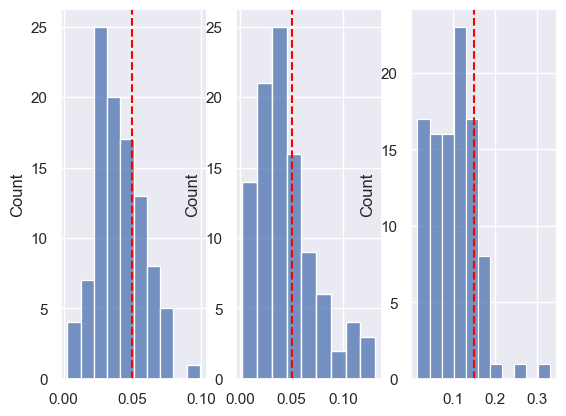

In [82]:
fig, axs = plt.subplots(1, 3)
fig.set_figheight(3)
fig.set_figwidth(9)

sns.histplot(np.exp(posterior_sample[:,0]),ax=axs[0])
axs[0].axvline(beta_true[0], color="red", linestyle="--")

sns.histplot(np.exp(posterior_sample[:,1]),ax=axs[1])
axs[1].axvline(beta_true[1], color="red", linestyle="--")

sns.histplot(np.exp(posterior_sample[:,2]),ax=axs[2])
axs[2].axvline(beta_true[2], color="red", linestyle="--")

plt.show()

### NPE

Hyperparameters: 1024 observations, network dimension 8, 400 training epochs

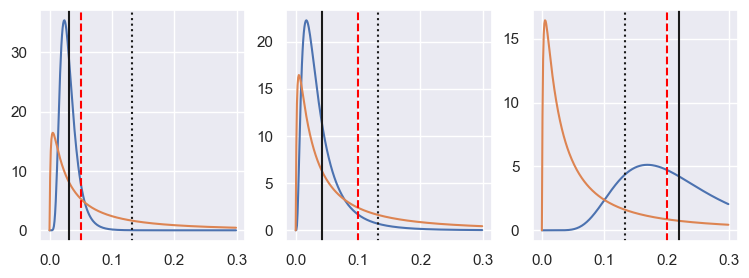

In [27]:
npe_mu = [-3.327, -3.588, -2.538]
npe_sigma = [0.54, 0.794, 0.607]
posterior_mean = np.exp(np.array(npe_mu) + np.array(npe_sigma)**2/2)
x = np.arange(0., 0.3, 0.001)
fig, axs = plt.subplots(1, 3)
fig.set_figheight(3)
fig.set_figwidth(9)

for i in range(3):
    sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(npe_mu[i]), s=npe_sigma[i]), 
                ax=axs[i])
    sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(prior_mu), s=prior_sigma),
                ax=axs[i])
    axs[i].axvline(beta_true[i], color="red", linestyle="--")
    axs[i].axvline(posterior_mean[i], color="k")
    axs[i].axvline(prior_mean, color="k", linestyle=":")
plt.show()

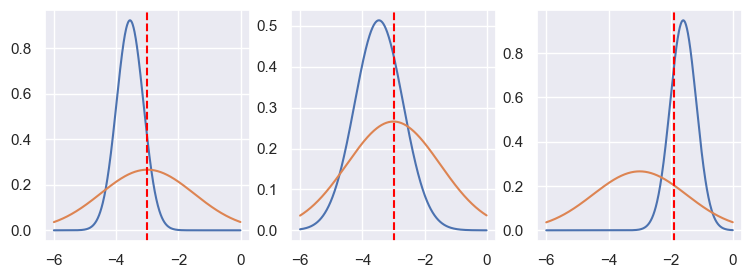

In [37]:
posterior_mean = np.exp(np.array(npe_mu) + np.array(npe_sigma)**2/2)
x = np.arange(-6., 0, 0.01)
fig, axs = plt.subplots(1, 3)
fig.set_figheight(3)
fig.set_figwidth(9)

for i in range(3):
    sns.lineplot(x=x, y=norm.pdf(x, npe_mu[i], npe_sigma[i]), 
                ax=axs[i])
    sns.lineplot(x=x, y=norm.pdf(x, prior_mu, prior_sigma),
                ax=axs[i])
    axs[i].axvline(np.log(beta_true[i]), color="red", linestyle="--")
plt.show()

## Posterior Predictive Checks

In [25]:
neural_posterior = multivariate_normal(npe_mu, np.diag(npe_sigma))
K = 30
npe_sample = np.exp(neural_posterior.rvs(size=K, random_state=2))
posterior_predictive = np.empty((K,n_zones+1, T))

si_model = SIModel(alpha, gamma, beta_true, 
                   n_zones, prior_mu, prior_sigma, 
                   N, T, summarize=False)
x_o = si_model.get_observed_data(29)
x_o = x_o.unflatten(1, (n_zones+1,T)).squeeze(0)

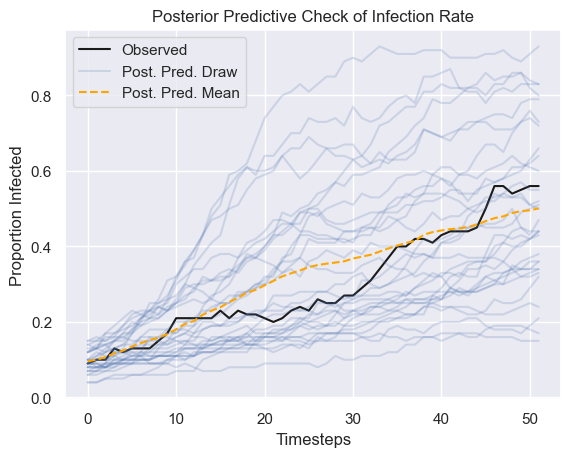

In [36]:
for i in range(K):
    si_model = SIModel(alpha, gamma, npe_sample[i], 
                   n_zones, prior_mu, prior_sigma,
                   N, T, summarize=False)
    x_rep = si_model.get_observed_data(i)
    x_rep = x_rep.unflatten(1, (n_zones+1, T)).squeeze(0)
    posterior_predictive[i] =  np.array(x_rep)
pp_mean = posterior_predictive.mean(0)[0]

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive[:,0,:].T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.title("Posterior Predictive Check of Infection Rate")
plt.ylabel("Proportion Infected")
plt.xlabel("Timesteps")
plt.show()